# Elaboration du Notre Modèle de Prediction

Nous voila enfin arrivé à la phase finale de notre projet , cele consistant à la creation et à l'evaluation de notre modèle.
Au sein de cette partie nous allons effectuer les taches suivantes:
- Data Sampling : consistera à subdiviser notre ensemblle d'apprentissage en une partie pour l'entrainement du modèle :(training set) et une autre pour le test et evaluation du modèle :(test set) nous utiliserons les techniques d'echantillonage de la librairie scikit-learn
- Feature Encoding : Vue que la plus part des algorithmes du machine learning ne fonctionnent qu'avec des données de nature numeriques , toutes nos variables seront encodées en variables binaires en utilisant la technique du one-hot encoding
- Shortlist - Pomissing models: Dans cette partie nous allons entrainer differents algorithmes du Machin Learning pour predire notre output à la fin nous ne  retiendrons que les modèles les plus prometteur après leur evaluation
- Enfin Nous allons optimiser les modèles et ne retenir que les modèles les plus prommeteur.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #for beatiful visualizations
%matplotlib inline 
import scipy.stats as scs #for statistics
import operator
from scipy.stats import chi2_contingency
import matplotlib.ticker as ticker
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import *

In [2]:
Techo=pd.read_csv("../dataset/DatasetTechno.csv",index_col="Unnamed: 0")
Medecine=pd.read_csv("../dataset/DatasetMedecine.csv",index_col="Unnamed: 0")
Economie=pd.read_csv("../dataset/DatasetEconomie.csv",index_col="Unnamed: 0")
dataset=pd.read_csv("../dataset/DatasetFinalV1.csv",index_col="Unnamed: 0")

In [30]:
sample=dataset.loc[dataset.FAC=='FM'].head(3).append( dataset.loc[dataset.FAC=='FSTA'].head(5).append(dataset.loc[dataset.FAC=='FSEG'].head(5))).append(dataset.loc[dataset.FAC=='FD'].head(3)).append(dataset.loc[dataset.FAC=='FT'].head(2)).append(dataset.loc[dataset.FAC=='FPSE'].head(4)).append(dataset.loc[dataset.FAC=='FSDC'].head(3))

In [37]:
sample[['ID','DIPPERC','AGE','GENDER','FAC','CGPA']].head(2)

,ID,DIPPERC,AGE,GENDER,FAC,CGPA
55,10384,59.0,22,F,FM,59.15
71,11610,52.0,23,H,FM,44.00


Commencons par la préparation des nos données pour les algorithmes

## Preparation des données pour les algorithmes 

Au sein de cette partie nous allons écrire des fonctions qui effectuerons la préparartion automatiques des nos données avant l'execution des algorithmes '

La premiere transformation que nous fairons sera l'encodage de nos données et pour celle ci nous allons utiliser la technique appelé one-hot encoding

Mais avant supprimons les colones qui n'ont aucun interet dans notre ensemble d'apprentissage.

Commencons par supprimer les colonnes sexe, age , pourcentage à l'exetat qui comme souligné au paragraphe précedant n'ont aucune influence sur notre variable finale

In [38]:
dataset.columns

Index([u'ID', u'SCHOOLSTATUS', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC',
       u'SCHOOLPROVINCE', u'GENDER', u'DIPPERC', u'AGE', u'CGPA',
       u'DistinctionRatio', u'EchecRatio', u'NACADYEAR',
       u'Pass1stSessionRatio'],
      dtype='object')

In [3]:
dataset.head(1)

,ID,SCHOOLSTATUS,SCHOOL_RIGHT,OPTION_RIGHT,FAC,SCHOOLPROVINCE,GENDER,DIPPERC,AGE,CGPA,DistinctionRatio,EchecRatio,NACADYEAR,Pass1stSessionRatio
0,3895,protestant,zanner,commmerciale et adm,FSEG,NORD-KIVU,H,52.0,31,59.400002,G,G,1.0,G


In [4]:
dataset.set_index(keys='ID',inplace=True)

now let get only the data with the CGPA after

Avant de continuer verifions les correlations existantes entre les colonnes SCHOOL,SCHOOLSTATUS, et SCHOOLPROVINCE

In [29]:
# %load ChiSquareCal.py
class ChiSquareCalc(object):
    """this class is designed to calculated and interpret the relationship between 2 categorials variables by computing the chi square test between them
    you can find more on chi square test on this video https://www.youtube.com/watch?v=misMgRRV3jQ
    it will use pandas , numpy ,searborn matplotlib , scipy
    """
    def __init__(self, X,Y,dataset,**kwargs):
        """we will initailise the with 2 colums of a datafrme the input must be a data and columns names"""
        if isinstance(dataset,pd.DataFrame) and isinstance(X,str)and isinstance(Y,str) and X in dataset.columns and Y in dataset.columns :
            if operator.and_(operator.__eq__(dataset[X].dtypes, 'object'),operator.__eq__(dataset[Y].dtypes, 'object')):
                self.dataset=dataset
                self.X=dataset[X]
                self.Y=dataset[Y]
                self.contingency=pd.DataFrame()
                self.c=0
                self.p=0
                self.dof=0
                self.q=0.95 #lower tail probability
                self.criticalValue=0
            else:
                raise TypeError('Class only deal wih categorial columns')
        else:
            raise TypeError('Columns names must be string and data must be a DataFrame')
    def contengencyTable(self):
        """this method will return a contengency table of the 2 variables"""
        self.contingency = pd.crosstab(self.X,self.Y)
        return self.contingency
    def chisquare(self):
        """this one will calculate the chi square value and return
        q: chi square results
        df: degree of freedom
        p: probability
        expexcted: excepected frequency table
        """
        if (not self.contingency.empty):
            self.c, self.p, self.dof, expected = chi2_contingency(self.contingency)
            return pd.DataFrame(expected,columns=self.contingency.columns,index=self.contingency.index)
        else:
            raise ValueError('contingency table must be initialised')
    def conclude(self,on):
        """
        we can decide to conclude on chi square value(chi) or on p (p)value
        Here is how we build the conclusion according to p value
         Probability of 0: It indicates that both categorical variable are dependent
         Probability of 1: It shows that both variables are independent.
         Probability less than 0.05: It indicates that the relationship between the variables is significant at 95% confidence
        And according to chi square value and df we use a ccritical value calculate with :
        q:lower tail probability
        df:degree of freedom
         the conclusion is approving or rejecting a null hypothesis
        """
        NulHyp='is no relationship between '+self.X+'and '+self.Y
        self.criticalValue=scs.chi2.ppf(q = self.q, df =self.dof)
        if on not in ['chi','p']:
            raise ValueError('choose chi or p')
        else:
            if on=='chi':
                if self.criticalValue > self.c:
                    return 'Accepted : '+NulHyp
                else:
                    return 'null hypothesis is rejected : There is a relationhip between the categorical variable'
            else:
                if self.p==0:
                    return ' It indicates that both categorical variable are dependent'
                elif self.p==1:
                    return 'It shows that both variables are independent'
                elif self.p <(1-self.q):
                    return 'It indicates that the relationship between the variables is significant at confidence of %s',self.q
                else:
                    return 'there is no relationship '
    def DrawPlot(self,**kwargs):
        """ and as for bonus you can draw plot to visualise the relationship """
        plt.figure(figsize= kwargs.get('size'))
        plt.title('Distribution de ' )
        plt.xlabel('Label')
        ax=sns.countplot(hue=self.X,y=self.Y,data=self.dataset,orient=kwargs.get('orient'))
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        return ax
        



In [11]:
SchoolStat=ChiSquareCalc(dataset=datasetCGPA,X='SCHOOL_RIGHT',Y='SCHOOLSTATUS')

In [12]:
SchoolStat.contengencyTable()

SCHOOLSTATUS,autodidacte,catholique,inconnu,kimbanguiste,musulman,privé,protestant,publique
SCHOOL_RIGHT,,,,,,,,
1uto,0,0,1,0,0,0,0,0
53,0,0,1,0,0,0,0,0
54,0,0,1,0,0,0,0,0
61,0,0,2,0,0,0,0,0
Alleluya,0,0,2,0,0,0,0,0
BWANGA,0,0,2,0,0,0,0,0
Bungulu Beni,0,0,1,0,0,0,0,0
GRACIA,0,0,1,0,0,0,0,0
I DE BKV,0,0,1,0,0,0,0,0


In [13]:
SchoolStat.chisquare()

SCHOOLSTATUS,autodidacte,catholique,inconnu,kimbanguiste,musulman,privé,protestant,publique
SCHOOL_RIGHT,,,,,,,,
1uto,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
53,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
54,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
61,0.018664,0.553977,0.293107,0.002121,0.016119,0.227359,0.581124,0.307529
Alleluya,0.018664,0.553977,0.293107,0.002121,0.016119,0.227359,0.581124,0.307529
BWANGA,0.018664,0.553977,0.293107,0.002121,0.016119,0.227359,0.581124,0.307529
Bungulu Beni,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
GRACIA,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765
I DE BKV,0.009332,0.276988,0.146554,0.001060,0.008059,0.113680,0.290562,0.153765


In [19]:
SchoolStat.conclude(on='chi')

0       null hypothesis is rejected : is no relationsh...
1       null hypothesis is rejected : is no relationsh...
2       null hypothesis is rejected : is no relationsh...
3       null hypothesis is rejected : is no relationsh...
4       null hypothesis is rejected : is no relationsh...
5       null hypothesis is rejected : is no relationsh...
6       null hypothesis is rejected : is no relationsh...
7       null hypothesis is rejected : is no relationsh...
8       null hypothesis is rejected : is no relationsh...
9       null hypothesis is rejected : is no relationsh...
10      null hypothesis is rejected : is no relationsh...
11      null hypothesis is rejected : is no relationsh...
12      null hypothesis is rejected : is no relationsh...
13      null hypothesis is rejected : is no relationsh...
14      null hypothesis is rejected : is no relationsh...
15      null hypothesis is rejected : is no relationsh...
16      null hypothesis is rejected : is no relationsh...
17      null h

In [18]:
SchoolStat.dof

4130

In [20]:
SchoolStat.p

0.0

Comme notre hypothese null es rejeter nous pouvons affirmativement conclure qu'il existe une relation entre l'ecole et le status de l'ecole'

DOnc connaissance l'ecole  nous pouvons savaoir le status

In [22]:
SchoolStat2=ChiSquareCalc(dataset=datasetCGPA,X='SCHOOL_RIGHT',Y='SCHOOLPROVINCE')

In [23]:
SchoolStat2.contengencyTable()

SCHOOLPROVINCE,BANDUNDU,BAS CONGO,EQUATEUR,K OR,KASAI OCCIDENTAL,KASAI ORIENTAL,KATANGA,KIGALI,KINSHASA,MANIEMA,NORD-KIVU,NYARUKENGE,ORIENTALE,OUEST,SUD-KIVU,inconnu
SCHOOL_RIGHT,,,,,,,,,,,,,,,,
1uto,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
53,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
54,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
61,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
Alleluya,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
BWANGA,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
Bungulu Beni,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
GRACIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
I DE BKV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [26]:
SchoolStat2.chisquare()

SCHOOLPROVINCE,BANDUNDU,BAS CONGO,EQUATEUR,K OR,KASAI OCCIDENTAL,KASAI ORIENTAL,KATANGA,KIGALI,KINSHASA,MANIEMA,NORD-KIVU,NYARUKENGE,ORIENTALE,OUEST,SUD-KIVU,inconnu
SCHOOL_RIGHT,,,,,,,,,,,,,,,,
1uto,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
53,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
54,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
61,0.005090,0.000848,0.001697,0.000424,0.001273,0.004242,0.010180,0.000848,0.029692,0.017391,1.569459,0.000424,0.035207,0.000848,0.312195,0.010180
Alleluya,0.005090,0.000848,0.001697,0.000424,0.001273,0.004242,0.010180,0.000848,0.029692,0.017391,1.569459,0.000424,0.035207,0.000848,0.312195,0.010180
BWANGA,0.005090,0.000848,0.001697,0.000424,0.001273,0.004242,0.010180,0.000848,0.029692,0.017391,1.569459,0.000424,0.035207,0.000848,0.312195,0.010180
Bungulu Beni,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
GRACIA,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090
I DE BKV,0.002545,0.000424,0.000848,0.000212,0.000636,0.002121,0.005090,0.000424,0.014846,0.008696,0.784730,0.000212,0.017603,0.000424,0.156098,0.005090


In [27]:
SchoolStat2.conclude(on='p')

' It indicates that both categorical variable are dependent'

In [28]:
SchoolStat2.conclude(on='chi')

0       null hypothesis is rejected : is no relationsh...
1       null hypothesis is rejected : is no relationsh...
2       null hypothesis is rejected : is no relationsh...
3       null hypothesis is rejected : is no relationsh...
4       null hypothesis is rejected : is no relationsh...
5       null hypothesis is rejected : is no relationsh...
6       null hypothesis is rejected : is no relationsh...
7       null hypothesis is rejected : is no relationsh...
8       null hypothesis is rejected : is no relationsh...
9       null hypothesis is rejected : is no relationsh...
10      null hypothesis is rejected : is no relationsh...
11      null hypothesis is rejected : is no relationsh...
12      null hypothesis is rejected : is no relationsh...
13      null hypothesis is rejected : is no relationsh...
14      null hypothesis is rejected : is no relationsh...
15      null hypothesis is rejected : is no relationsh...
16      null hypothesis is rejected : is no relationsh...
17      null h

In [30]:
SchoolStat2.dof

8850

In [6]:
dataset.columns

Index([u'SCHOOLSTATUS', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC',
       u'SCHOOLPROVINCE', u'GENDER', u'DIPPERC', u'AGE', u'CGPA',
       u'DistinctionRatio', u'EchecRatio', u'NACADYEAR',
       u'Pass1stSessionRatio'],
      dtype='object')

In [7]:
datasetCGPA=dataset[['DIPPERC', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC' , u'CGPA','DistinctionRatio','EchecRatio','Pass1stSessionRatio']]

Dans une premiere approche nous allons utiliser le dataset CGPA pour la construction de notre modèle car ils ne contiendra uniquement que 3 attribues et reste seront utiliser ulterieurment

Nous allons construire notre ensemble d'apprentissage uniquement sur base de ces attribues  , les autres on été supprimées car ils ne disposent d'aucune corrlation avec le CGPA

In [5]:
datasetCGPA.head(5)

,SCHOOLSTATUS,SCHOOL_RIGHT,OPTION_RIGHT,SCHOOLPROVINCE,FAC,CGPA
0,protestant,zanner,commmerciale et adm,NORD-KIVU,FSEG,59.400002
1,protestant,zanner,commmerciale et adm,NORD-KIVU,FSEG,40.000000
2,protestant,zanner,commmerciale et adm,NORD-KIVU,FSEG,61.299999
3,protestant,zanner,commmerciale et adm,NORD-KIVU,FSEG,60.599998
4,protestant,zanner,commmerciale et adm,NORD-KIVU,FSEG,48.599998


Avant de passer a l'encodage nous allons remplacer certaines écoles moins representé par un et un seul unique groupe  appéle autres école

In [60]:
len(datasetCGPA.SCHOOL_RIGHT.value_counts())

591

Nous pouvons aisement remarquer que nos étudiant proviennent de plus pret de 600 écoles differentes , nous allons essayer de reduire ces ecoles en essayans de prendre les écoles qui ont un maximum de 6 éleves à la fa

In [67]:
len(datasetCGPA.SCHOOL_RIGHT.value_counts()[datasetCGPA.SCHOOL_RIGHT.value_counts()>5])

133

Nous pouvons voir que la solution comme suggere ici https://datascience.stackexchange.com/a/9447/30464 nous allons utilser 
    la technique du one hot encoding suivie par celle de PCA Principal Component analysis pour les attribues comme la valeur de l'ecole de provenance qui dispose de plus de 596 differents valeurs'

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

In [ ]:
datasetCGPA.to_csv('../dataset/DatasetCGPA.csv')
datasetFin.to_csv('DatasetFinalV1.csv')
Techno.to_csv("DatasetTechno.csv")
Medecine.to_csv('DatasetMedecine.csv')
Economie.to_csv('DatasetEconomie.csv')
Droit.to_csv('DatasetDroit.csv')
Sante.to_csv('DatsetSante.csv')
Psyco.to_csv('DatasetPsycho.csv')
Teologie.to_csv('DatasetTeo.csv')

Commencons par proceder à l'encodage des toutes nos  variables categorielle en utilisant notre techique du one hot encoding

In [6]:
enc= LabelBinarizer()
X_train_1=datasetCGPA[[u'SCHOOLSTATUS', u'SCHOOL_RIGHT', u'OPTION_RIGHT',u'SCHOOLPROVINCE']]
X=datasetCGPA[['FAC','CGPA']]
catCol=X_train_1.columns
for col in catCol:
    # creating an exhaustive list of all possible categorical values
    
    data=dataset[[col]]
    enc.fit(data)
    # Fitting One Hot Encoding on train data
    temp = enc.transform(dataset[[col]])
    # Changing the encoded features into a data frame with new column names
    temp=pd.DataFrame(temp,columns=[ col + '-' +i for i in data[col].value_counts().index])
    # In side by side concatenation index values should be same
    # Setting the index values similar to the X_train data frame
    temp=temp.set_index(dataset.index)
    # adding the new One Hot Encoded varibales to the train data frame
    X=pd.merge(temp,X,right_index=True,left_index=True)

In [7]:
len(dataset.SCHOOL_RIGHT.value_counts()) + len(dataset.OPTION_RIGHT.value_counts()) +len(dataset.SCHOOLSTATUS.value_counts())  +  len(dataset.SCHOOLPROVINCE.value_counts())

645

In [21]:
X.columns

Index([u'SCHOOLPROVINCE-NORD-KIVU', u'SCHOOLPROVINCE-SUD-KIVU',
       u'SCHOOLPROVINCE-ORIENTALE', u'SCHOOLPROVINCE-KINSHASA',
       u'SCHOOLPROVINCE-MANIEMA', u'SCHOOLPROVINCE-inconnu',
       u'SCHOOLPROVINCE-KATANGA', u'SCHOOLPROVINCE-BANDUNDU',
       u'SCHOOLPROVINCE-KASAI ORIENTAL', u'SCHOOLPROVINCE-EQUATEUR',
       ...
       u'SCHOOLSTATUS-protestant', u'SCHOOLSTATUS-catholique',
       u'SCHOOLSTATUS-publique', u'SCHOOLSTATUS-inconnu',
       u'SCHOOLSTATUS-privé', u'SCHOOLSTATUS-autodidacte',
       u'SCHOOLSTATUS-musulman', u'SCHOOLSTATUS-kimbanguiste', u'FAC',
       u'CGPA'],
      dtype='object', length=647)

Après notre encodage nous pouvons aisement remarquer que notre ensemble d'apprentissage vient de passer de (4715, 4 )à (4715 , 647) et nous pouvons constater qu'on vient de l'elargir et ça risque de nous pauser un problème de performences lors de l'execution des algorithmes sur le training set!
Nous allons proceder ainsi pour le reste de du travail:
- Entrainer les algoritmes au sein de chaque faculté  et evaluer grace à une validation croisée
- Ensuite pour l'algorithme SVM nous allons proceder à une reduction des dimensions ensuite comparer les performances des algorithmes avant et après l'evaluation du modèle

Comme pour les chapitres précedants nous entrainerons et evaluerons nos modèles facultés par faculté enfin et enfin prédire le maximun de notre variable CGPA au sein de chaque faculté 

Nous pouvons aussi echelonner notre variable final le cGPA en le divisant par 100

In [24]:
X.loc[:,'CGPA']=X.CGPA/100

##### 1. Faculté de Medecine

Pour commencer notre entrainement nous alons echantilloner nos donnes pour constituter un ensemble d'apprentissahe (Training set), et un ensemble d'evaluation du modèle (test set)

In [10]:
Medecine=datasetCGPA.loc[datasetCGPA.FAC=='FM']

In [11]:
Medecine.columns

Index([u'DIPPERC', u'SCHOOL_RIGHT', u'OPTION_RIGHT', u'FAC', u'CGPA',
       u'DistinctionRatio', u'EchecRatio', u'Pass1stSessionRatio'],
      dtype='object')

Dans une premiere approche nous allons constituer notre training set et test set qui sera representatif des nos données 

In [14]:
Medecine.DistinctionRatio.value_counts()*100/len(Medecine)

G    97.520661
D     1.239669
A     1.239669
Name: DistinctionRatio, dtype: float64

In [15]:
Medecine.Pass1stSessionRatio.value_counts()*100/len(Medecine)

G    68.595041
A    20.247934
D    11.157025
Name: Pass1stSessionRatio, dtype: float64

In [16]:
Medecine.EchecRatio.value_counts()*100/len(Medecine)

G    71.074380
A    20.247934
D     8.677686
Name: EchecRatio, dtype: float64

Nous allons proceder à un echantillonage stratifier pour constituer notre training set et notre test set nous prendrons les individus dans 2 categories differentes ceux qui ont un CGPA superieur à 50% et ceux dont le CPGA est inferieur à 50%

In [26]:
len(Medecine.loc[Medecine.CGPA<55])*100/len(Medecine)

25

In [27]:
len(Medecine.loc[Medecine.CGPA>=55])*100/len(Medecine)

74

In [93]:
len(Medecine.loc[Medecine.DIPPERC<55])*100/len(Medecine)

28

In [94]:
len(Medecine.loc[Medecine.DIPPERC>=55])*100/len(Medecine)

71

Nous allons efefctuer un  echantillonager stratifier dans chaque categorie des nos variables echec ratio, distinction ratio, Passage en premiere session ratio ensuite cree une union des indices pour avoir un ensemble d'apprentissage et un ensemble d'evaluation.

In [50]:
Medecine.reset_index(inplace=True)

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

In [84]:
for train_index, test_index in split.split(Medecine, Medecine.EchecRatio):
    Med_Train=Medecine.loc[train_index]
    Med_Test=Medecine.loc[test_index]

In [92]:
len(Med_Train.loc[Med_Train.DIPPERC<55])*100/float(len(Med_Train))

28.497409326424872

In [91]:
len(Med_Test.loc[Med_Test.DIPPERC<55])*100/float(len(Med_Test))

28.571428571428573

Nous allons effetuer un echantillonage stratifier en fonction de la colonne echec ratio, nous allons prendre les individus deans chque categrie

In [ ]:
nous pouvons constater que notre echantilonage est bien effectuer car les proportions des diplome percentage et CGPA sont 

In [ ]:
Medecine_Train=Medecine.loc[]

#### Réduction des Dimensions

Avant d'essayer la réduction des dimmensions nous notons cette remarquons ceci du livre handons on a MAchine learning Project

In [80]:
from sklearn.decomposition import PCA

In [88]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.98) + 1

In [89]:
d

348

In [85]:
np.sum(pca.explained_variance_ratio_)

0.99999999999999967

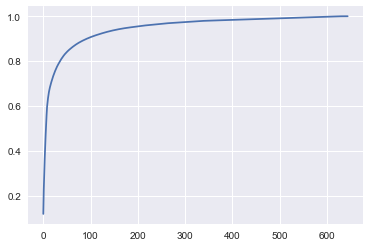

In [87]:
plt.plot(cumsum)
plt.show()

In [8]:
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

In [9]:
X.shape

(4715, 647)

In [ ]:
a